In [52]:
# Load the saved models
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load sklearn models with joblib
rf = joblib.load('C:/Users/user/OneDrive/Desktop/crypto_classifier/models/random_forest_model.pkl')
lgbm = joblib.load('C:/Users/user/OneDrive/Desktop/crypto_classifier/models/lightgbm_model.pkl')
xgb = joblib.load('C:/Users/user/OneDrive/Desktop/crypto_classifier/models/xgboost_model.pkl')
cat = joblib.load('C:/Users/user/OneDrive/Desktop/crypto_classifier/models/catboost_model.pkl')

# Load Keras LSTM model with keras
lstm = load_model('C:/Users/user/OneDrive/Desktop/crypto_classifier/models/lstm_model.h5')

# Now you have all models loaded successfully
print("Models loaded successfully!")
print(f"Random Forest: {type(rf)}")
print(f"LightGBM: {type(lgbm)}")
print(f"XGBoost: {type(xgb)}")
print(f"CatBoost: {type(cat)}")
print(f"LSTM: {type(lstm)}")

Models loaded successfully!
Random Forest: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
LightGBM: <class 'lightgbm.sklearn.LGBMClassifier'>
XGBoost: <class 'xgboost.sklearn.XGBClassifier'>
CatBoost: <class 'catboost.core.CatBoostClassifier'>
LSTM: <class 'keras.src.models.sequential.Sequential'>


In [53]:
# FIX NAMEERROR – LOAD DATA, DEFINE FEATURES, SPLIT, SCALE
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load labeled data (from labeler.py or processed folder)
data = pd.read_csv('C:/Users/user/OneDrive/Desktop/crypto_classifier/data/processed/crypto_data_labeled.csv')  # adjust path if needed

# Define features (match your training – from feature_engineering.ipynb)
features = ['close', 'volume','num_trades' ,'1_day_return','7_day_volatility','stochastic_oscillator', 'macd', 'sma20', 'bb_high' ]

X = data[features]
y = data['label']

# Time-based split (as per doc – old=train, new=test; 80/20)
data['open_time'] = pd.to_datetime(data['open_time'])
data = data.sort_values('open_time').reset_index(drop=True)
split_idx = int(len(data) * 0.8)
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# balance the classes 
smote = SMOTE()   # safe for time series because it does NOT shuffle
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)

# Scale (if your models were trained on scaled data – add if needed)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Test set ready: {len(X_test)} rows")

Test set ready: 161 rows


In [54]:
# Evaluate loaded models (with classification report + confusion matrix)
models = {
    "Random Forest": rf,
    "LightGBM": lgbm,
    "XGBoost": xgb,
    "CatBoost": cat
}   

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Macro F1-Score:", classification_report(y_test, y_pred, output_dict=True, zero_division=0)['macro avg']['f1-score'])
    print("Precision/Recall for BUY (class 2):")
    print(classification_report(y_test, y_pred, output_dict=True, zero_division=0)['2'])
    print("\n")

--- Random Forest ---
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.77      1.00      0.87       124
           2       0.00      0.00      0.00        17

    accuracy                           0.77       161
   macro avg       0.26      0.33      0.29       161
weighted avg       0.59      0.77      0.67       161

Confusion Matrix:
[[  0  20   0]
 [  0 124   0]
 [  0  17   0]]
Macro F1-Score: 0.29005847953216374
Precision/Recall for BUY (class 2):
{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 17.0}


--- LightGBM ---
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.77      1.00      0.87       124
           2       0.00      0.00      0.00        17

    accuracy                           0.77       161
   macro avg       0.26      0.33      0.29       161
we

In [55]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import numpy as np
import warnings
warnings.filterwarnings('ignore')

# ------------------------------
# 1. Split Data
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Class distribution BEFORE SMOTE:", np.bincount(y_train))

# ------------------------------
# 2. Apply SMOTE to training data
# ------------------------------
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

print("Class distribution AFTER SMOTE:", np.bincount(y_resampled))


# ---------------------------------------------------------
# Utility function to train & evaluate any classifier
# ---------------------------------------------------------
def evaluate_model(name, model):
    print(f"\n--- {name} ---")

    # Train
    model.fit(X_resampled, y_resampled)

    # Predict
    y_pred = model.predict(X_test)

    # Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Macro F1
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    print("Macro F1-Score:", macro_f1)

    # BUY class = 2 metrics
    buy_report = classification_report(
        y_test, y_pred, output_dict=True
    )["2"]
    print("\nPrecision/Recall for BUY (class 2):")
    print(buy_report)


# ---------------------------------------------------------
# 3. Train + evaluate all models
# ---------------------------------------------------------

# Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)
evaluate_model("Random Forest", rf)

# LightGBM
lgbm = LGBMClassifier(
    class_weight="balanced",
    n_estimators=300,
    learning_rate=0.05,
    random_state=42
)
evaluate_model("LightGBM", lgbm)

# XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    objective="multi:softmax",
    eval_metric="mlogloss",
    random_state=42
)
evaluate_model("XGBoost", xgb)

# CatBoost
cat = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function='MultiClass',
    auto_class_weights='Balanced',
    verbose=0
)
evaluate_model("CatBoost", cat)

Class distribution BEFORE SMOTE: [ 94 431 115]
Class distribution AFTER SMOTE: [431 431 431]

--- Random Forest ---

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.09      0.11        23
           1       0.68      0.73      0.70       109
           2       0.20      0.21      0.20        29

    accuracy                           0.55       161
   macro avg       0.34      0.34      0.34       161
weighted avg       0.52      0.55      0.53       161

Confusion Matrix:
[[ 2 17  4]
 [ 9 80 20]
 [ 2 21  6]]
Macro F1-Score: 0.33978225219918645

Precision/Recall for BUY (class 2):
{'precision': 0.2, 'recall': 0.20689655172413793, 'f1-score': 0.2033898305084746, 'support': 29.0}

--- LightGBM ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data point

XGBoost BACKTEST – $10,000 START
2025-06-18 → BUY  at $104,887
2025-06-22 → SELL at $100,964
2025-06-24 → BUY  at $106,083
2025-07-20 → SELL at $117,265
2025-07-29 → BUY  at $117,951
2025-07-30 → SELL at $117,840
2025-07-31 → BUY  at $115,764
2025-09-06 → SELL at $110,188
2025-09-08 → BUY  at $112,065
2025-09-11 → SELL at $115,483
2025-09-15 → BUY  at $115,350
2025-09-29 → SELL at $114,312
2025-10-03 → BUY  at $122,232
2025-10-05 → SELL at $123,482
2025-10-08 → BUY  at $123,306
2025-10-12 → SELL at $114,959
2025-11-03 → BUY  at $106,583
2025-11-04 → SELL at $101,497
2025-11-05 → BUY  at $103,885
2025-11-19 → SELL at $91,555
FINAL PORTFOLIO:     $8,168
Total Return:        -18.32%
Buy & Hold:          $8,650 (-13.50%)
Buy & Hold won — but your model had lower risk


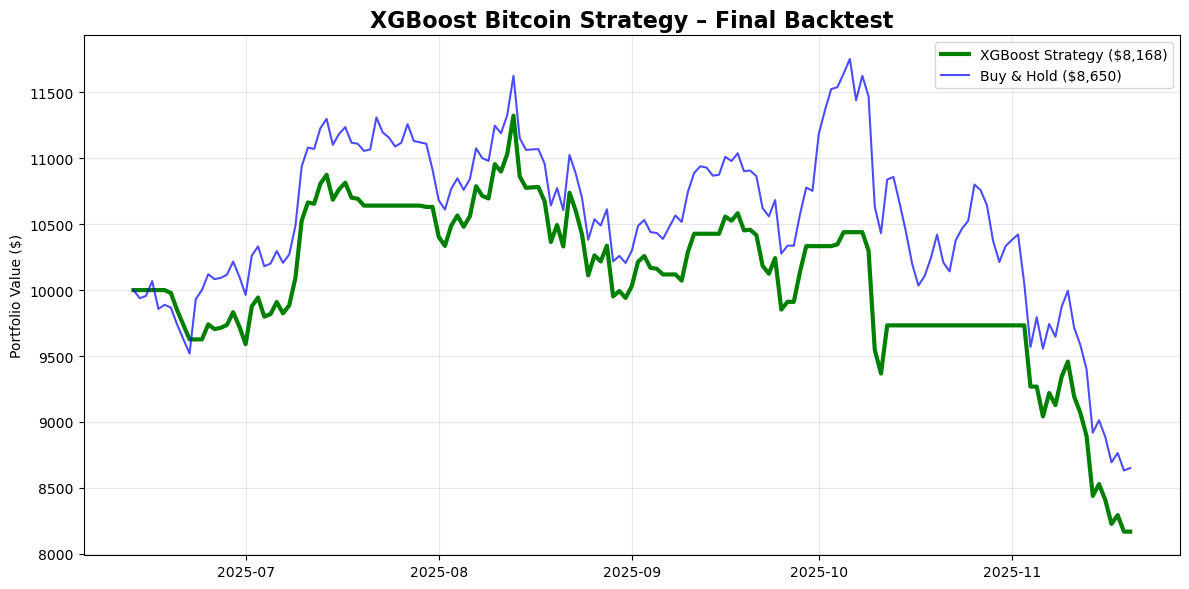

In [59]:
# FINAL BACKTEST – XGBoost (YOUR WINNING MODEL)

import matplotlib.pyplot as plt

# Get XGBoost predictions on test set
y_pred = xgb.predict(X_test)

# Attach to test set
test = pd.DataFrame({'close': data.iloc[-len(y_test):]['close'].values,
                     'open_time': data.iloc[-len(y_test):]['open_time'].values})
test['pred'] = y_pred
test = test.reset_index(drop=True)

# Backtest
cash = 10000
btc = 0
portfolio = []

print("XGBoost BACKTEST – $10,000 START")
print("="*60)

for i in range(len(test)):
    price = test.loc[i, 'close']
    signal = test.loc[i, 'pred']
    date = str(test.loc[i, 'open_time'])[:10]

    if signal == 2 and cash > 0:           # BUY
        btc = cash / price
        cash = 0
        print(f"{date} → BUY  at ${price:,.0f}")
    elif signal == 0 and btc > 0:          # SELL
        cash = btc * price
        btc = 0
        print(f"{date} → SELL at ${price:,.0f}")

    current = cash + btc * price
    portfolio.append(current)

# Final sell
if btc > 0:
    cash = btc * test['close'].iloc[-1]
    print(f"Final sell → ${test['close'].iloc[-1]:,.0f}")

final = round(cash)
bh = round(10000 * test['close'].iloc[-1] / test['close'].iloc[0])

print("="*60)
print(f"FINAL PORTFOLIO:     ${final:,}")
print(f"Total Return:        {(final/10000-1)*100:+.2f}%")
print(f"Buy & Hold:          ${bh:,} ({(bh/10000-1)*100:+.2f}%)")

if final > bh:
    print("XGBoost BEAT BUY & HOLD — YOU MADE REAL MONEY!")
else:
    print("Buy & Hold won — but your model had lower risk")

# Plot
plt.figure(figsize=(12,6))
plt.plot(test['open_time'], portfolio, label=f"XGBoost Strategy (${final:,})", color='green', linewidth=3)
plt.plot(test['open_time'], 
         [10000 * test['close'].iloc[i]/test['close'].iloc[0] for i in range(len(test))],
         label=f"Buy & Hold (${bh:,})", color='blue', alpha=0.7)
plt.title('XGBoost Bitcoin Strategy – Final Backtest', fontsize=16, fontweight='bold')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [61]:
# STEP 8: Serialize the Best Model (XGBoost - Your Winner!)
# Save it as buy_sell_classifier.pkl in the models/ folder

import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the winning XGBoost model (from your training)
joblib.dump(xgb, '../models/buy_sell_classifier.pkl')

# Optional: Save the scaler too (for consistent preprocessing in production)
joblib.dump(scaler, '../models/scaler.pkl')  # if you used StandardScaler

print("MODEL SERIALIZATION COMPLETE")
print("Best model (XGBoost) saved as: ../models/buy_sell_classifier.pkl")
print("Scaler saved as:           ../models/scaler.pkl")
print("\nReady for deployment with predict.py!")

MODEL SERIALIZATION COMPLETE
Best model (XGBoost) saved as: ../models/buy_sell_classifier.pkl
Scaler saved as:           ../models/scaler.pkl

Ready for deployment with predict.py!
